In [78]:
import numpy as np
np.random.seed(420)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection
import sklearn.calibration
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

preProcFeatsnew = np.load('./processed.files/labelled/featuresnew.npy')
preProcFeatsnewred = np.load('./redfeatnew.npy')
preProcLabelsnew = np.load('./processed.files/labelled/labelsnew.npy')

#preProcFeats = np.load('./processed.files/labelled/featuresold.npy')
preProcFeats = np.load('./redfeatold.npy')
preProcLabels = np.load('./processed.files/labelled/labelsold.npy')

print preProcFeats.shape
print preProcFeatsnew.shape

(12398, 125)
(12398, 481)


In [79]:
clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0,
            warm_start=False),
            n_jobs=1)

k_fold = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeats,\
                                                            preProcLabels, test_size=0.25, random_state=420)

In [80]:
clf.fit(X_train, y_train)
prob_pos_old = clf.predict_proba(X_test)[:, 7]

#Binarise the classification
y_test[y_test != 9] = 0

frac_pos_old, mean_pred_value_old = calibration_curve(y_test, prob_pos_old, n_bins=10)

In [81]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeatsnew,\
                                                            preProcLabelsnew, test_size=0.25, random_state=420)

In [82]:
clf.fit(X_train, y_train)

prob_pos = clf.predict_proba(X_test)[:, 7]
y_test[y_test != 9] = 0
frac_pos, mean_pred_value = calibration_curve(y_test, prob_pos, n_bins=10)

In [83]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeatsnewred,\
                                                            preProcLabelsnew, test_size=0.25, random_state=420)

In [84]:
clf.fit(X_train, y_train)

prob_pos_red = clf.predict_proba(X_test)[:, 7]
y_test[y_test != 9] = 0
frac_pos_red, mean_pred_value_red = calibration_curve(y_test, prob_pos_red, n_bins=10)

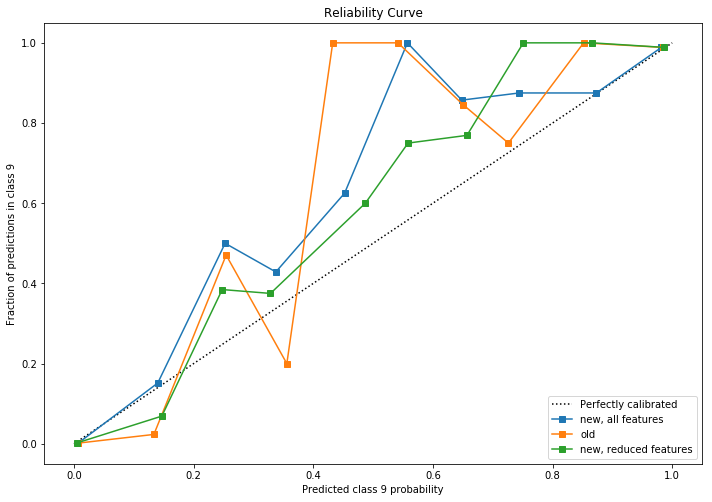

In [85]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_pred_value, frac_pos, "s-", label="new, all features")
ax1.plot(mean_pred_value_old, frac_pos_old, "s-", label="old" )
ax1.plot(mean_pred_value_red, frac_pos_red, "s-", label="new, reduced features" )

ax1.set_ylabel("Fraction of predictions in class 9")
ax1.set_xlabel("Predicted class 9 probability")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability Curve')
plt.savefig('graphs/relcurve.png')

plt.tight_layout()
plt.show()

### Training and calibration sets MUST be disjoint!

In [86]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeatsnew,\
                                                            preProcLabelsnew, test_size=0.25, random_state=420)

y_test[y_test != 9] = 0
y_test[y_test == 9] = 1

y_train[y_train != 9] = 0
y_train[y_train == 9] = 1


valfrac = 0.25
print y_train.shape, X_train.shape
size = y_train.flatten().size
frac = int(0.25*size)

X_valid, y_valid = X_train[frac:size], y_train[frac:size]
X_train, y_train = X_train[:frac], y_train[:frac]
X_train_valid, y_train_valid = X_train[:frac], y_train[:frac]

# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
#clf_probs9 = clf_probs[:,7]
#clf_probsn9 = np.sum(clf_probs[:, :6], axis = 1)
score = 
print score

# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
cal_clf = sklearn.calibration.CalibratedClassifierCV(clf, method="isotonic", cv="prefit")
# cal_clf.fit(X_valid, y_valid)
# cal_clf_probs = cal_clf.predict_proba(X_test)
# cal_score = sklearn.metrics.log_loss(y_test, cal_clf_probs)
print cal_score

(9298,) (9298, 481)
0.075109192059
0.0511382303301


In [87]:
print cal_clf_probs.shape
print y_test.shape

frac_pos_cal, mean_pred_value_cal = calibration_curve(y_test, cal_clf_probs[:,1], n_bins=10)

(3100, 2)
(3100,)


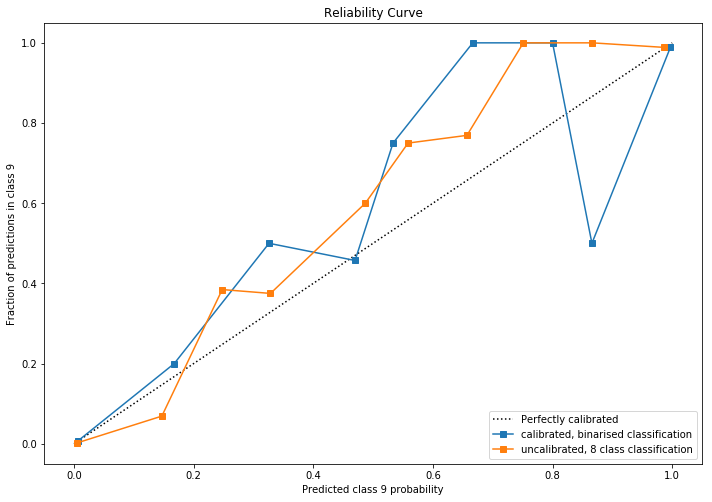

In [88]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_pred_value_cal, frac_pos_cal, "s-", label="calibrated, binarised classification" )
ax1.plot(mean_pred_value_red, frac_pos_red, "s-", label="uncalibrated, 8 class classification" )

ax1.set_ylabel("Fraction of predictions in class 9")
ax1.set_xlabel("Predicted class 9 probability")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability Curve')
plt.savefig('graphs/relcurvecal.png')

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeatsnew,\
                                                            preProcLabelsnew, test_size=0.25, random_state=420)

y_test[y_test != 9] = 0
y_test[y_test == 9] = 1

y_train[y_train != 9] = 0
y_train[y_train == 9] = 1

cal_clf = sklearn.calibration.CalibratedClassifierCV(clf, method="isotonic")

print np.mean(sklearn.model_selection.cross_val_score(cal_clf, preProcFeats, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss'))

